# jaxeffort introduction

In this notebook we will show how to use some capabilities from `jaxeffort`.In this tutorial you will learn how to instantiate some trained emulators, run them and get jacobians as evaluated from AD systems.

We start by loading the required packages.

In [1]:
import numpy as np
import jaxeffort
import jax
import matplotlib.pyplot as plt
import json
plt.rcParams['text.usetex'] = True

Initializing neutrino interpolants with dual-grid strategy...
Creating F_interpolant grid...
Creating dFdy_interpolant grid...
F grid: 1100 points from 0.001000 to 1000.0
dFdy grid: 20000 points from 0.001000 to 1000.0
Computing F values...
Computing dFdy values...
Creating Akima interpolators...
Dual-grid interpolants initialized successfully!
jaxeffort: Initializing multipole emulators...
  Loading pybird_mnuw0wacdm...
  pybird_mnuw0wacdm: Loaded 3/3 multipoles (l=['0', '2', '4'])
  Loading velocileptors_lpt_mnuw0wacdm...
  velocileptors_lpt_mnuw0wacdm: Loaded 3/3 multipoles (l=['0', '2', '4'])
  Loading velocileptors_rept_mnuw0wacdm...
  velocileptors_rept_mnuw0wacdm: Loaded 3/3 multipoles (l=['0', '2', '4'])


`jaxeffort` comes batteries included with some trained emulators. They can be accessed by

In [2]:
P0 = jaxeffort.trained_emulators["velocileptors_rept_mnuw0wacdm"]["0"]
P2 = jaxeffort.trained_emulators["velocileptors_rept_mnuw0wacdm"]["2"]
P4 = jaxeffort.trained_emulators["velocileptors_rept_mnuw0wacdm"]["4"]

You can get a description of the emulator, together with the parameters the emulator handles, by

In [3]:
P0.P11.emulator_description

{'author': 'Marco Bonici',
 'author_email': 'bonici.marco@gmail.com',
 'miscellanea': 'The emulator has been trained using CLASS and velocileptors. The training dataset has been created by passing P_cb to velocileptors, assuming there is only one massive neutrino.',
 'parameters': 'z, ln10^10 As, ns, H0, omega_b, omega_c, Mnu, w0, wa.'}

You can see their input parameter ranges by (they are in the same order as in the above description)

In [4]:
P0.P11.in_MinMax

Array([[ 2.85004037e-01,  1.89999596e+00],
       [ 2.00000375e+00,  3.49999625e+00],
       [ 8.00000750e-01,  1.09999775e+00],
       [ 5.00001000e+01,  8.99999000e+01],
       [ 2.00000125e-02,  2.49999875e-02],
       [ 8.00002500e-02,  1.79999750e-01],
       [ 3.75000000e-06,  4.99996250e-01],
       [-2.99999125e+00,  4.99991250e-01],
       [-2.99998750e+00,  1.99998750e+00]], dtype=float64)

Now, let us come to the usage of `jaxeffort`. First, let us define some input cosmological parameters (we define here using a dictionary just because it is convenient later for the comparison with `velocileptors`).

We also define some dummy bias parameters. Here we also show how to compute the growth factor by using our built-in ODE solver (this is fundamental for the rescaling part).

In [5]:
# Set up some fiducial values for the parameters
#
# pars: the biases and counter terms.
# b1,b2,bs,b3: linear, quadratic & cubic bias parameters
# alpha0,alpha2,alpha4,alpha6: counterterms
# sn0,sn2,sn4: stochastic contributions to P(k) and sigma^2 (here labeled by powers of mu).
#
biases = [0.7, 0.26, 0.67, 0.52]      # [b1, b2, bs, b3]
cterms = [-3.4, -1.7, 6.5, 0.0]       # [alpha0, alpha2, alpha4, alpha6]
stoch  = [1500., -1900., 0.0] 
b   = biases + cterms + stoch

cosmo_dict = {
    "ln10As": 3.2,
    "ns": 0.96,
    "H0": 74.,
    "ombh2": 0.022,
    "omch2": 0.12,
    "Mν": 0.06,
    "w0": -1.5,
    "wa": -1.2,
    "z": 1.2,
}

cosmo = jaxeffort.W0WaCDMCosmology(
            ln10As=cosmo_dict["ln10As"],
            ns=cosmo_dict["ns"],
            h=cosmo_dict["H0"]/100,
            omega_b=cosmo_dict["ombh2"],
            omega_c=cosmo_dict["omch2"],
            m_nu=cosmo_dict["Mν"],
            w0=cosmo_dict["w0"],
            wa=cosmo_dict["wa"]
        )


θ = np.array([cosmo_dict["z"], cosmo_dict["ln10As"], cosmo_dict["ns"], cosmo_dict["H0"], cosmo_dict["ombh2"], cosmo_dict["omch2"], cosmo_dict["Mν"], cosmo_dict["w0"],cosmo_dict["wa"]])
D = cosmo.D_z(cosmo_dict["z"])

After this prep work has been done, you just have to feed these three elements to `jaxeffort`.

In [6]:
P0.get_Pl(θ, b, D);

Ok, fine, but are these operations fast? Let's benchmark them.

In [7]:
%timeit cosmo.D_z(cosmo_dict["z"])#single redshift benchmark

363 μs ± 3.8 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [8]:
%timeit cosmo.D_z(np.linspace(0., 3., 30))#multiple redshift benchmark

481 μs ± 87.8 μs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [9]:
%timeit P0.get_Pl(θ, b, D)

47.3 μs ± 3.04 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


Great! Now, let us show how to compute the jacobian of these calculations! In the pure functional style approach that is leveraged by `jax`, let us define an utility function and then differentiate it.

In [10]:
# Define function for P0 that depends only on θ
def P0_func(theta):
    return P0.get_Pl(theta, b, D)

# Compute Jacobian: shape (80, 9) - 80 k-bins, 9 cosmological parameters
jacobian_P0 = jax.jacfwd(P0_func)(θ)
print(f"Jacobian shape: {jacobian_P0.shape}")

Jacobian shape: (80, 9)


Let us benchmark that as well

In [11]:
%timeit jax.jacfwd(P0_func)(θ)

1.24 ms ± 53.6 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


Let us now plot the results of these calculations

In [12]:
k = P0.P11.k_grid

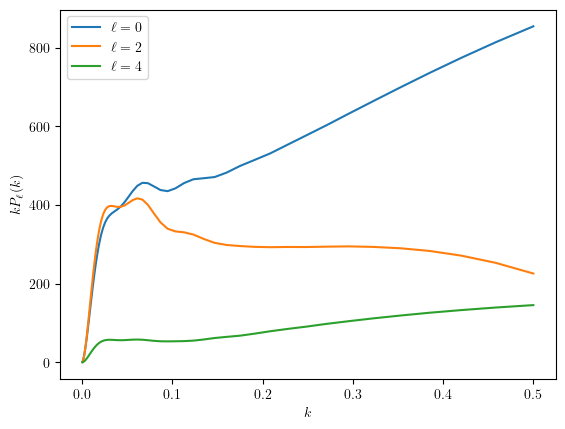

In [13]:
plt.plot(k, k*P0.get_Pl(θ, b, D), label = r"$\ell=0$")
plt.plot(k, k*P2.get_Pl(θ, b, D), label = r"$\ell=2$")
plt.plot(k, k*P4.get_Pl(θ, b, D), label = r"$\ell=4$")
plt.xlabel(r'$k$')
plt.ylabel(r'$kP_\ell(k)$')
plt.legend()

Text(0, 0.5, '$\\partial P_0(k)/\\partial\\alpha$')

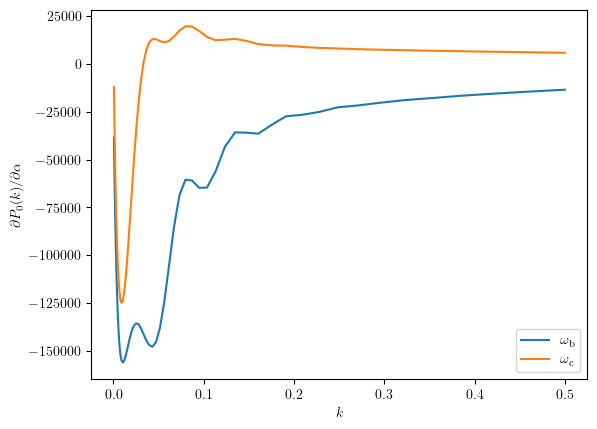

In [14]:
plt.plot(k, jacobian_P0[:,4], label = r"$\omega_\mathrm{b}$")
plt.plot(k, jacobian_P0[:,5], label = r"$\omega_\mathrm{c}$")
plt.legend()
plt.xlabel(r'$k$')
plt.ylabel(r'$\partial P_0(k)/\partial\alpha$')

Now, let us focus on some validations. How does it compare with the original `velocileptors`?

**Important**. Here everything is set to use the exact same settings used to create the training dataset. If you want something different this is fine, but you will need a different emulator. If you want to chang the input cosmological parameters, just change the initial dictionary.

In [15]:
# Generate multipoles using CLASS + PyBird (like in training data generation)
import numpy as np
from classy import Class
from velocileptors.EPT.ept_fullresum_fftw import REPT
from velocileptors.Utils.pnw_dst import pnw_dst


z = cosmo_dict["z"]

# Setup CLASS parameters
cosmo_params = {
    "output": "mPk",
    "P_k_max_h/Mpc": 20.0,
    "z_pk": "0.0,3.",
    "h": cosmo_dict["H0"] / 100,
    "omega_b": cosmo_dict["ombh2"],
    "omega_cdm": cosmo_dict["omch2"],
    "ln10^{10}A_s": cosmo_dict["ln10As"],
    "n_s": cosmo_dict["ns"],
    "tau_reio": 0.0568,
    "N_ur": 2.033,
    "N_ncdm": 1,
    "m_ncdm": cosmo_dict["Mν"],
    "use_ppf": "yes",
    "w0_fld": cosmo_dict["w0"],
    "wa_fld": cosmo_dict["wa"],
    "fluid_equation_of_state": "CLP",
    "cs2_fld": 1.0,
    "Omega_Lambda": 0.0,
    "Omega_scf": 0.0
}

# Initialize CLASS and compute
M = Class()
M.set(cosmo_params)
M.compute()

# Get growth rate
f = M.scale_independent_growth_factor_f(z)

# Generate k values and compute linear power spectrum
konhmin = 1e-3
konhmax = 10
nk = 20000
konh = np.logspace(np.log10(konhmin), np.log10(konhmax), nk)
plin = np.array([M.pk_cb(k * M.h(), z) * M.h()**3 for k in konh])

# Compute no-wiggle power spectrum using DST method
knw, Pnw = pnw_dst(konh, plin)

# Define target k-grid (from Julia code)
kv_target = np.concatenate(([0.0005,],
                             np.logspace(np.log10(0.0015), np.log10(0.025), 10, endpoint=True),
                             np.arange(0.03, 0.51, 0.01)))

# Initialize REPT with fine grid (will interpolate to target grid later if needed)
PT = REPT(knw, plin, pnw=Pnw, kmin=5e-4, kmax=0.5, nk=80,
          beyond_gauss=True, one_loop=True, N=2000, extrap_min=-6, extrap_max=2, cutoff=100, threads=1)

# Compute tables
PT.compute_redshift_space_power_multipoles_tables(f, apar=1.0, aperp=1.0, ngauss=4)

# Combine bias terms to get final multipoles
k_v, P0_velocileptors, P2_velocileptors, P4_velocileptors = PT.compute_redshift_space_power_multipoles(b, f, apar=1.0, aperp=1.0)

print(f"CLASS+velocileptors computation complete!")

CLASS+velocileptors computation complete!


In [16]:
# Compare emulator vs CLASS+PyBird
# Compute with emulator
P0_emu = P0.get_Pl(θ, b, D)
P2_emu = P2.get_Pl(θ, b, D)
P4_emu = P4.get_Pl(θ, b, D)

Now, let us compare the two results! We will show both the two lines in the same plot and the percentage residuals.

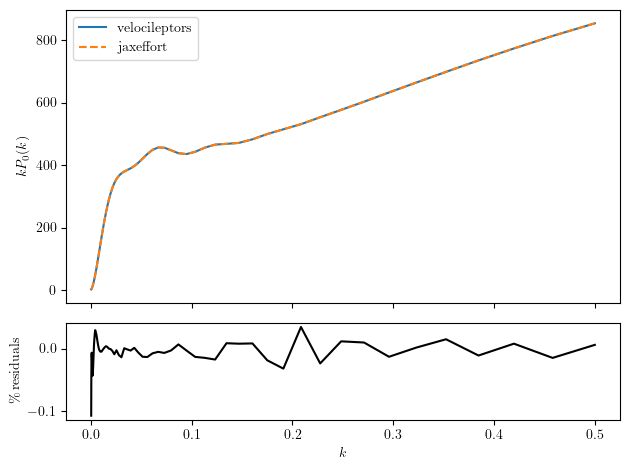

In [17]:
ratio  = P0_velocileptors / P0_emu

fig, (ax_top, ax_bot) = plt.subplots(
    2, 1,
    sharex=True,
    gridspec_kw={"height_ratios": [3, 1]},  # top three times taller
)

# ─── Top panel: power spectra ────────────────────────────────
ax_top.plot(k, k*P0_velocileptors, label=r'$\mathrm{velocileptors}$')
ax_top.plot(k, k*P0_emu, label=r'$\mathrm{jaxeffort}$', linestyle ="--")
ax_top.set_ylabel(r'$kP_0(k)$')
ax_top.legend()

# ─── Bottom panel: ratio ─────────────────────────────────────
ax_bot.plot(k, 100*(1-ratio), color='k')
ax_bot.set_xlabel(r'$k$')
ax_bot.set_ylabel(r'$\%\,\mathrm{residuals}$')

plt.tight_layout()
plt.show()

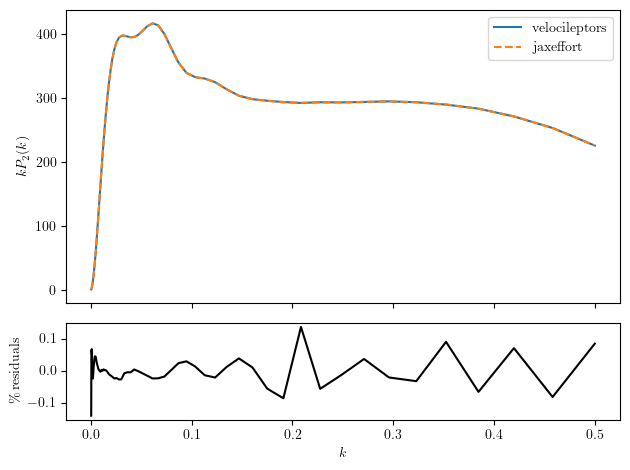

In [18]:
ratio  = P2_velocileptors / P2_emu  

fig, (ax_top, ax_bot) = plt.subplots(
    2, 1,
    sharex=True,
    gridspec_kw={"height_ratios": [3, 1]},  # top three times taller
)

# ─── Top panel: power spectra ────────────────────────────────
ax_top.plot(k, k*P2_velocileptors, label=r'$\mathrm{velocileptors}$')
ax_top.plot(k, k*P2_emu, label=r'$\mathrm{jaxeffort}$', linestyle ="--")
ax_top.set_ylabel(r'$kP_2(k)$')
ax_top.legend()

# ─── Bottom panel: ratio ─────────────────────────────────────
ax_bot.plot(k, 100*(1-ratio), color='k')
ax_bot.set_xlabel(r'$k$')
ax_bot.set_ylabel(r'$\%\,\mathrm{residuals}$')

plt.tight_layout()
plt.show()

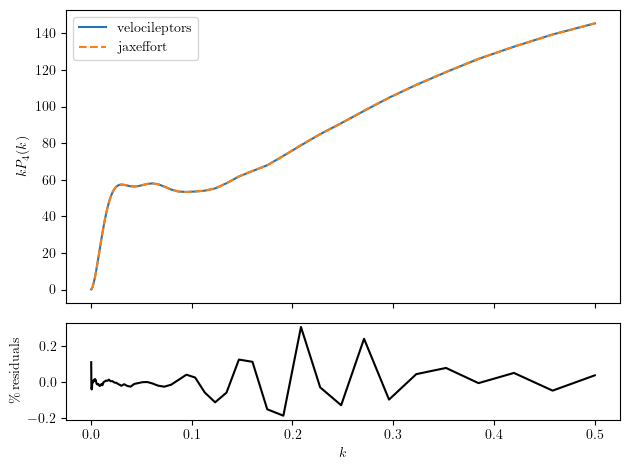

In [19]:
ratio = P4_velocileptors / P4_emu

fig, (ax_top, ax_bot) = plt.subplots(
    2, 1,
    sharex=True,
    gridspec_kw={"height_ratios": [3, 1]},  # top three times taller
)

# ─── Top panel: power spectra ────────────────────────────────
ax_top.plot(k, k*P4_velocileptors, label=r'$\mathrm{velocileptors}$')
ax_top.plot(k, k*P4_emu, label=r'$\mathrm{jaxeffort}$', linestyle ="--")
ax_top.set_ylabel(r'$kP_4(k)$')
ax_top.legend()

# ─── Bottom panel: ratio ─────────────────────────────────────
ax_bot.plot(k, 100*(1-ratio), color='k')
ax_bot.set_xlabel(r'$k$')
ax_bot.set_ylabel(r'$\%\,\mathrm{residuals}$')

plt.tight_layout()
plt.show()